## Problem Statement
Financial inclusion remains a critical challenge across many African countries, with large segments of the population still excluded from formal banking services. Understanding the demographic, social, and economic factors that influence whether individuals own a bank account is essential for improving access to financial products. However, the decision to open and maintain a bank account is not uniform and depends on multiple factors such as age, education, household size, location, and employment type. Without data-driven insights, policymakers, NGOs, and financial institutions struggle to design targeted strategies that effectively promote financial inclusion.

Objective:
This project aims to build a predictive machine learning model that determines the likelihood of an individual owning a bank account based on demographic and socio-economic attributes. Beyond prediction, the analysis seeks to uncover the key drivers of financial inclusion, identify underserved groups, and provide actionable insights for policymakers and financial institutions. Ultimately, the project contributes toward bridging the financial inclusion gap by enabling better-informed decisions to expand access to formal financial services.

Dataset Description:
The dataset consists of survey responses collected from multiple African countries, focusing on demographic and socio-economic characteristics. Below are the descriptions of the key variables:
- country → The country where the respondent is located.
- year → Year in which the survey was conducted.
- uniqueid → Unique identifier for each respondent.
- bank_account → Indicates whether the respondent owns a bank account.
- location_type → Respondent’s residence type, categorized as either Urban or Rural.
- cellphone_access → Whether the respondent has access to a mobile phone.
- household_size → Number of individuals living in the respondent’s household.
- age_of_respondent → Age of the respondent in years.
- gender_of_respondent → Respondent’s gender.
- relationship_with_head → Respondent’s relationship to the head of household.
- marital_status → Marital status of the respondent.
- education_level → Highest level of formal education attained by the respondent.
- job_type → Type of employment or occupation of the respondent.

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler,RobustScaler, StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, ConfusionMatrixDisplay

## Upload the data

In [390]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [391]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## General EDA

In [392]:
train.shape

(23524, 13)

In [393]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


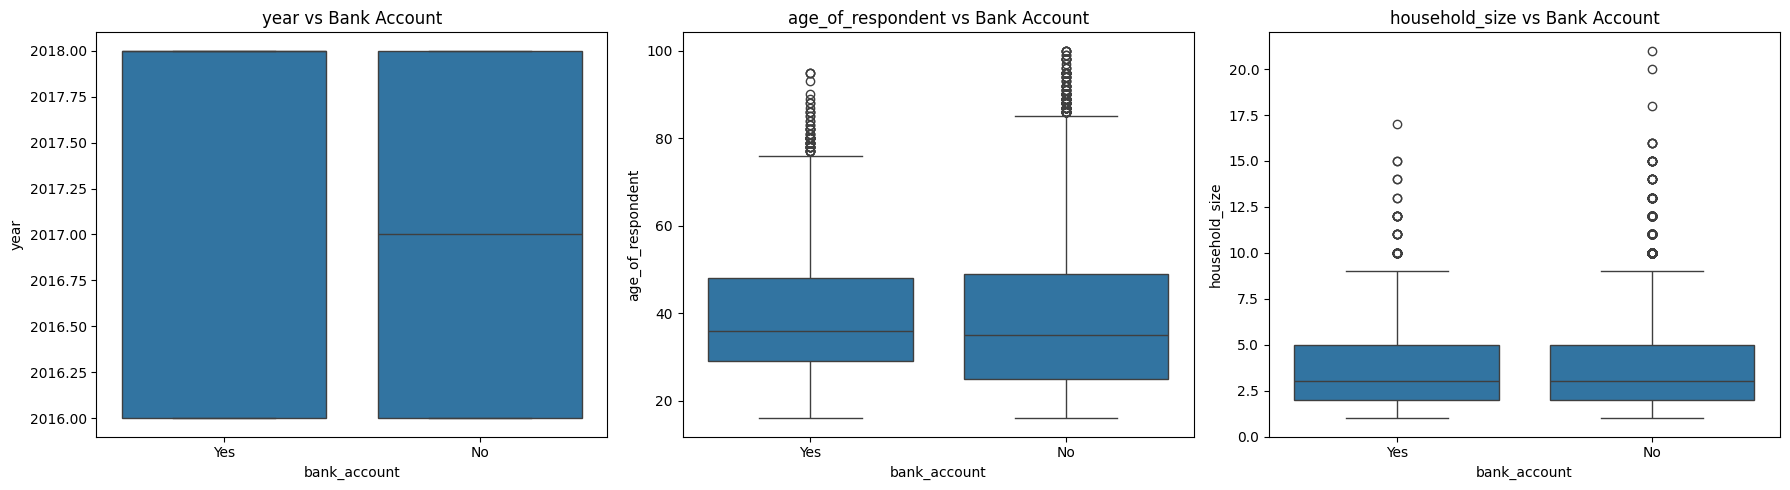

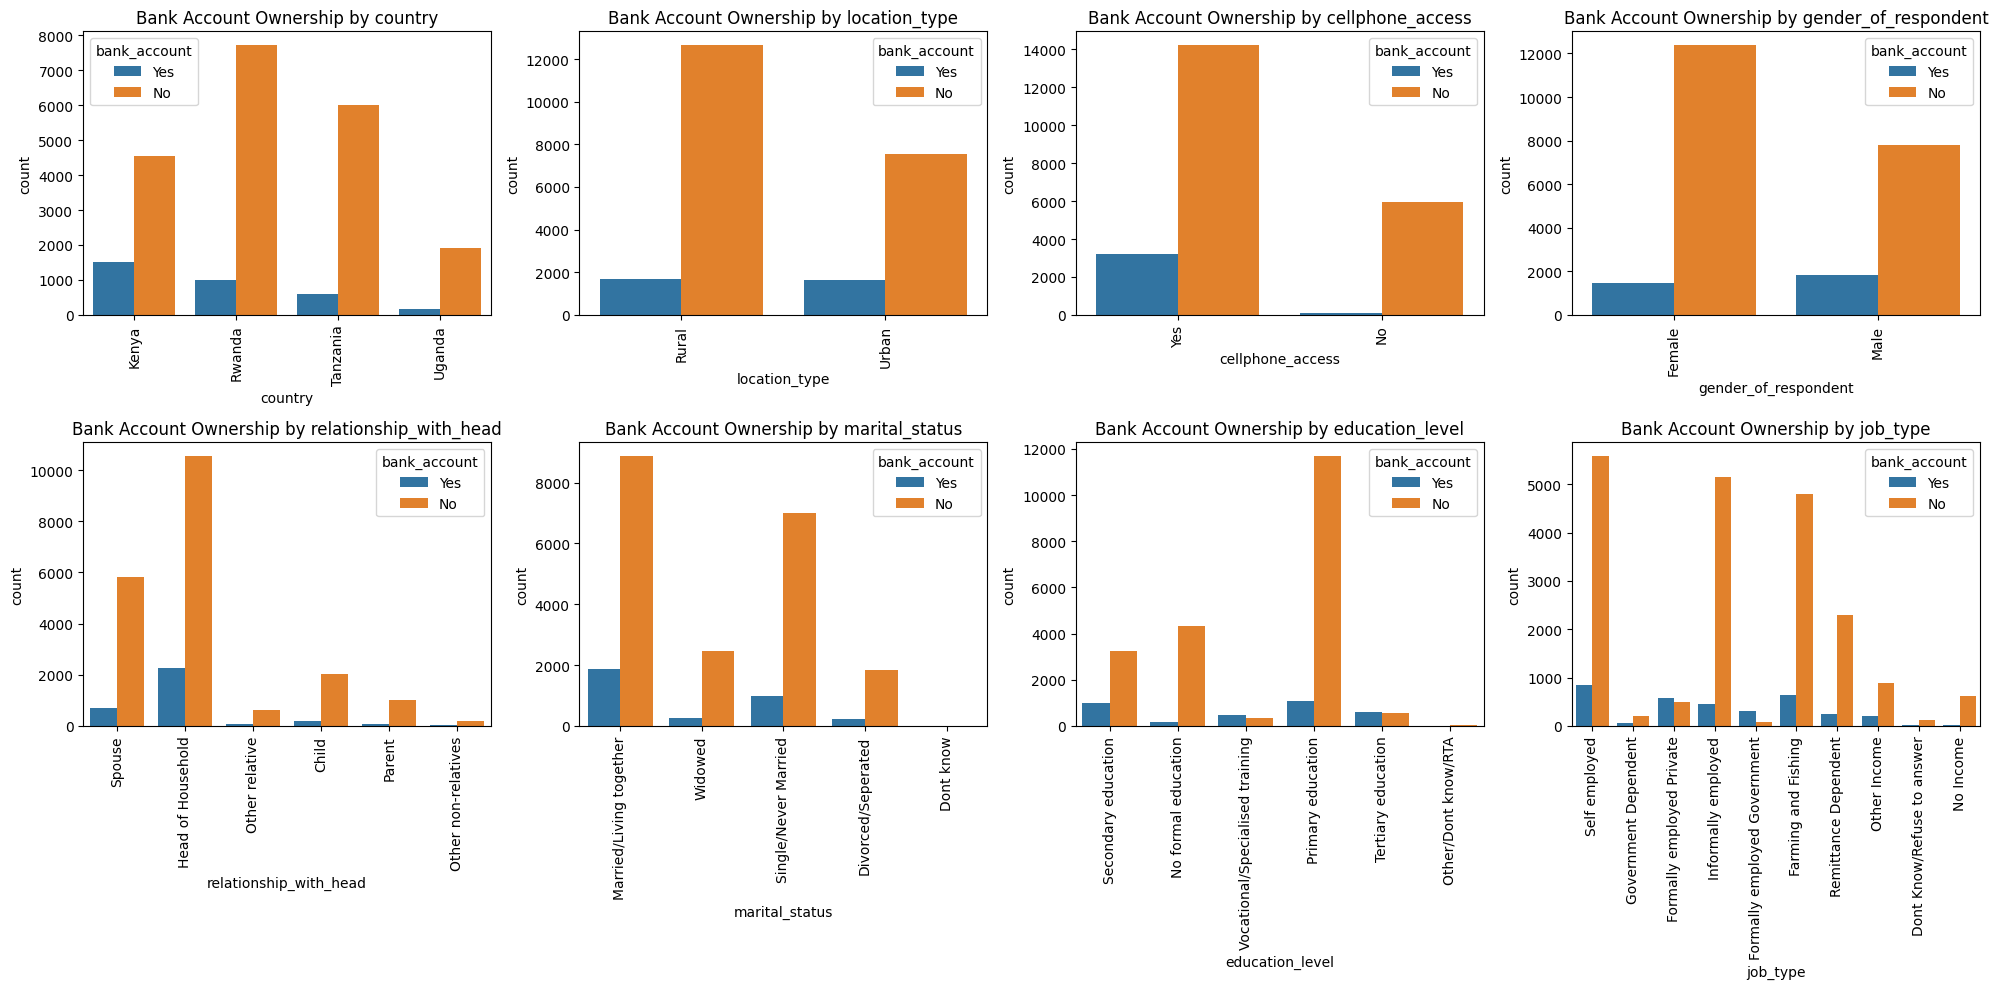

In [394]:
# Univeriate
# numerical columns
numeric_cols = ["year", 'age_of_respondent', 'household_size']
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(6*len(numeric_cols), 5))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x="bank_account", y=col, data=train, ax=axes[i])
    axes[i].set_title(f"{col} vs Bank Account")

plt.tight_layout()
plt.show()

# Categorical
categorical_cols = ['country','location_type','cellphone_access','gender_of_respondent','relationship_with_head','marital_status','education_level','job_type']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=train, x=col, hue='bank_account', ax=axes[i])
    axes[i].set_title(f"Bank Account Ownership by {col}")
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

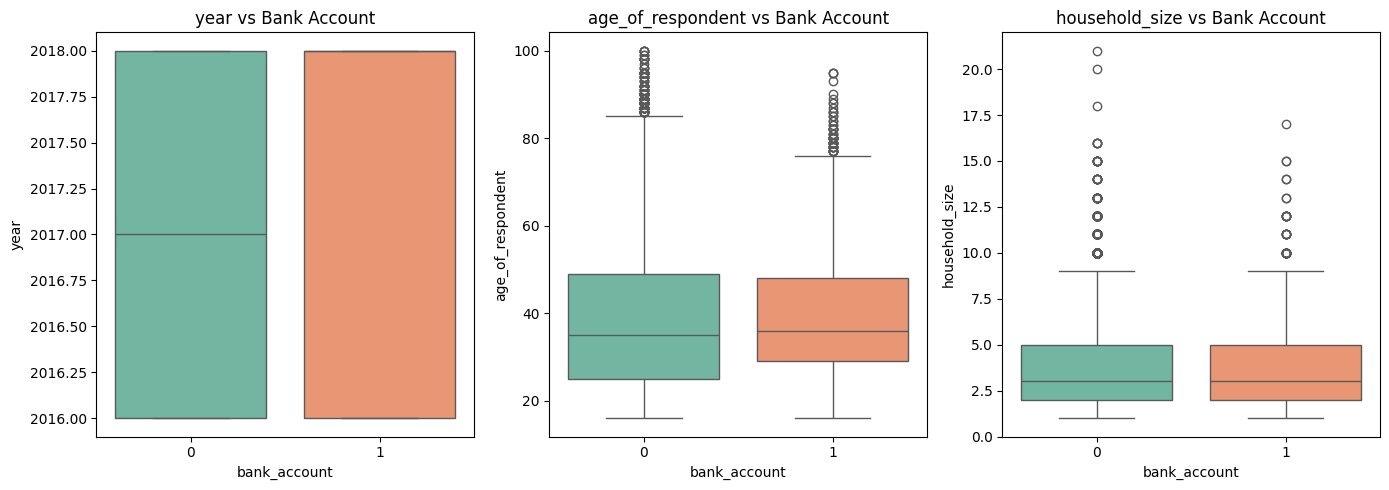

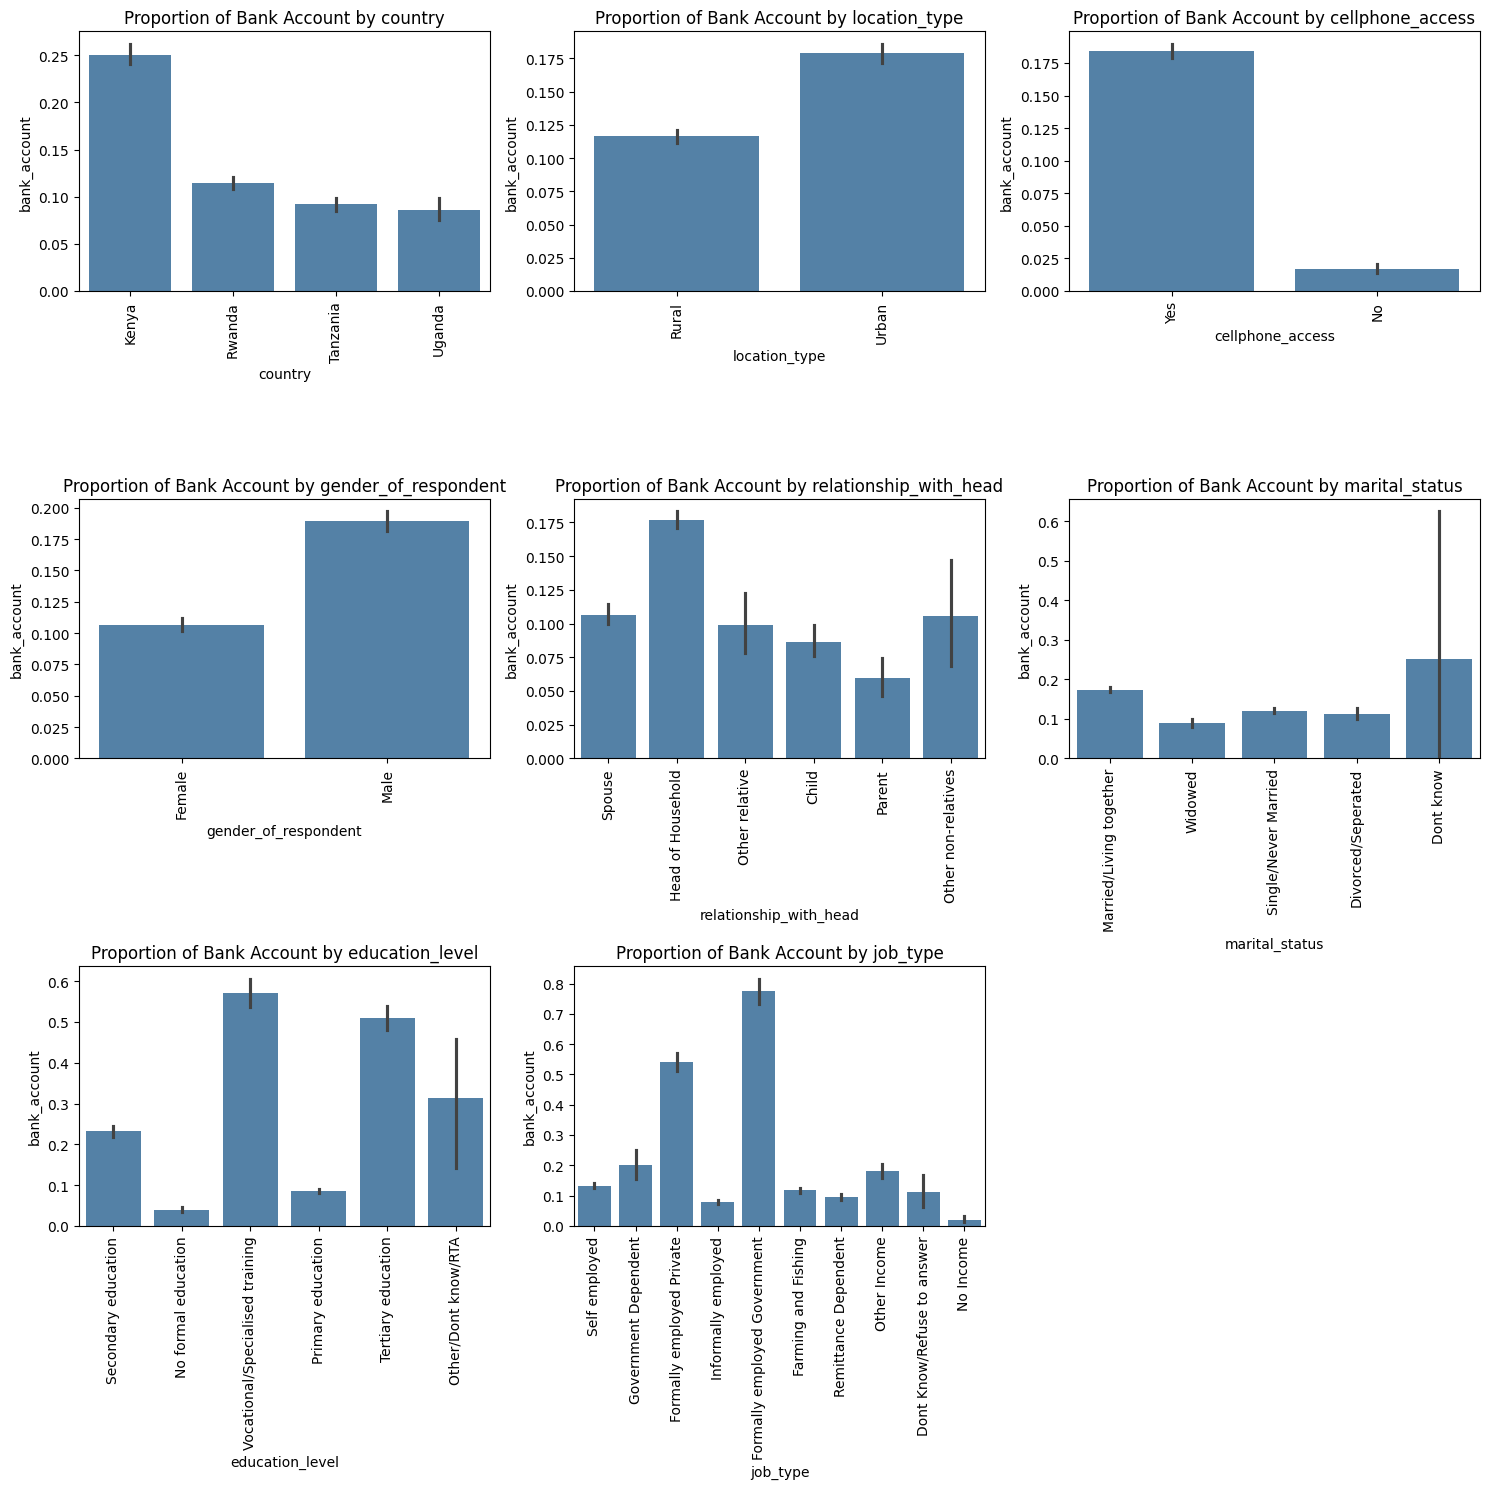

In [452]:
# Biveriate
# Numeric
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(14, 5))

for i, col in enumerate(numeric_cols):
    sns.boxplot(
        x="bank_account", 
        y=col, 
        data=train,
        hue="bank_account", 
        dodge=False, 
        legend=False, 
        palette="Set2", 
        ax=axes[i]
    )
    axes[i].set_title(f"{col} vs Bank Account")

plt.tight_layout()
plt.show()

# Categorical
n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.barplot(
        x=col,
        y="bank_account",
        data=train,
        estimator=lambda x: sum(x)/len(x),
        color="steelblue",
        ax=axes[i]
    )
    axes[i].set_title(f"Proportion of Bank Account by {col}")
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- 'year' and 'household_size' variables do not show a strong association with bank account ownership. 'Age of respondent' shows a minor difference, with individuals having bank accounts potentially having a slightly lower median age, although both groups span a wide age range.
- Cellphone access is strongly linked to bank account ownership
- gender gap exists, with males exhibiting higher ownership rates than females.
- Formal and self-employed individuals, particularly in "Private" sectors and "Farming and Fishing," demonstrate higher rates of bank account ownership compared to those with "No Income."
- Higher education levels correlate with increased bank account ownership
- urban populations are more likely to own accounts than rural populations.
- Bank account ownership is higher in Kenya and Rwanda compared to Tanzania and Uganda.

Trends

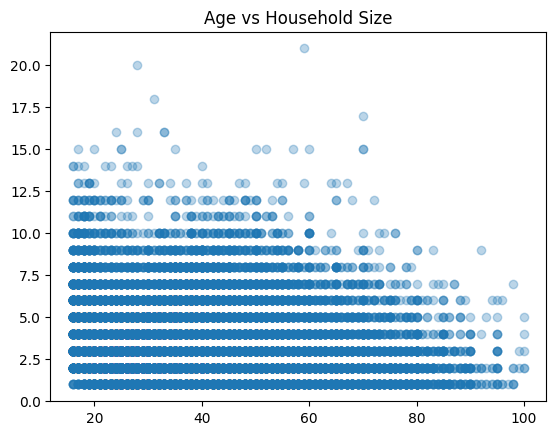

In [396]:
# Age vs Household Size
plt.scatter(train['age_of_respondent'], train['household_size'], alpha=0.3)
plt.title('Age vs Household Size')
plt.show()

While younger ages exhibit a broad spectrum of household sizes, likely reflecting diverse living arrangements and family formation, middle ages show a concentration in mid-range household sizes, possibly indicating periods of raising families. As age increases, particularly in older individuals, there's a trend towards smaller household sizes, suggesting reduced family units.

<Axes: xlabel='gender_of_respondent', ylabel='household_size'>

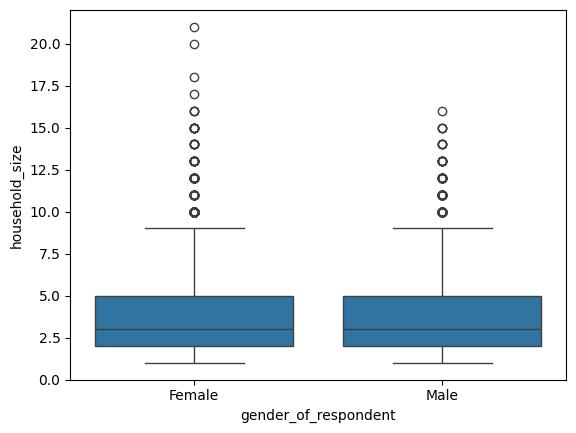

In [397]:
# Household Size vs Gender
sns.boxplot(x='gender_of_respondent', y='household_size', data=train)

The median household size is quite similar between households where the respondent is female and those where the respondent is male. However, households with female respondents show a slightly wider spread compared to those with male respondents, suggesting a bit more variability in the common household sizes for female-headed or female-represented households.

<Axes: xlabel='cellphone_access', ylabel='count'>

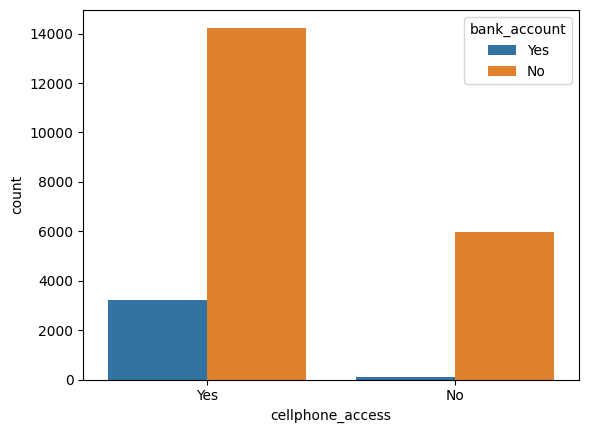

In [398]:
# Cellphone access vs Bank account
sns.countplot(x='cellphone_access', hue='bank_account', data=train)

While cellphone access is widespread, particularly among those represented, bank account ownership is not as prevalent, even among cellphone users. The lack of cellphone access almost entirely correlates with a lack of bank account ownership in this dataset.

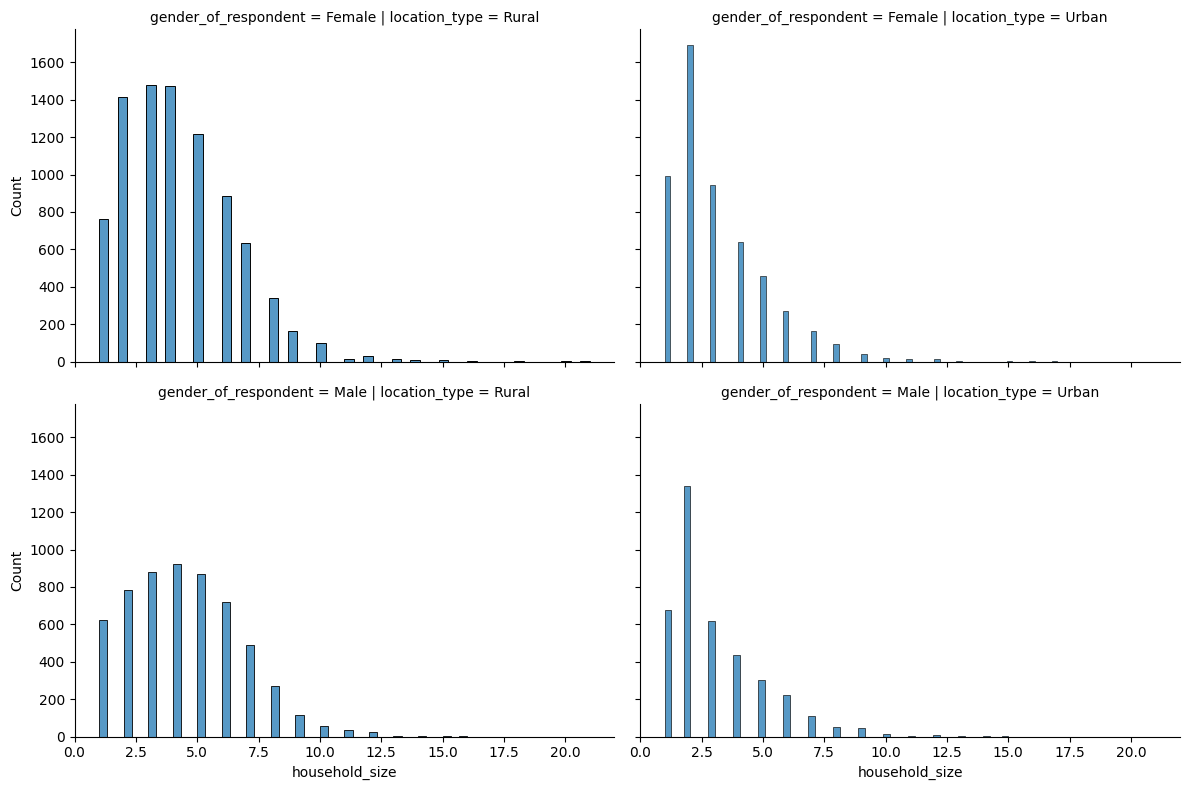

In [399]:
g = sns.FacetGrid(train, col='location_type', row='gender_of_respondent', height=4, aspect=1.5)
g.map(sns.histplot, 'household_size')

A significant difference in household size distribution is observed between rural and urban locations, regardless of the respondent's gender. Rural areas consistently show a broader distribution with higher frequencies of larger households, while urban areas are dominated by smaller household sizes. 

## ML-Specific EDA

In [400]:
train.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [401]:
train.duplicated().sum()

np.int64(0)

All columns have complete data, with no missing values or duplicates

Distribution

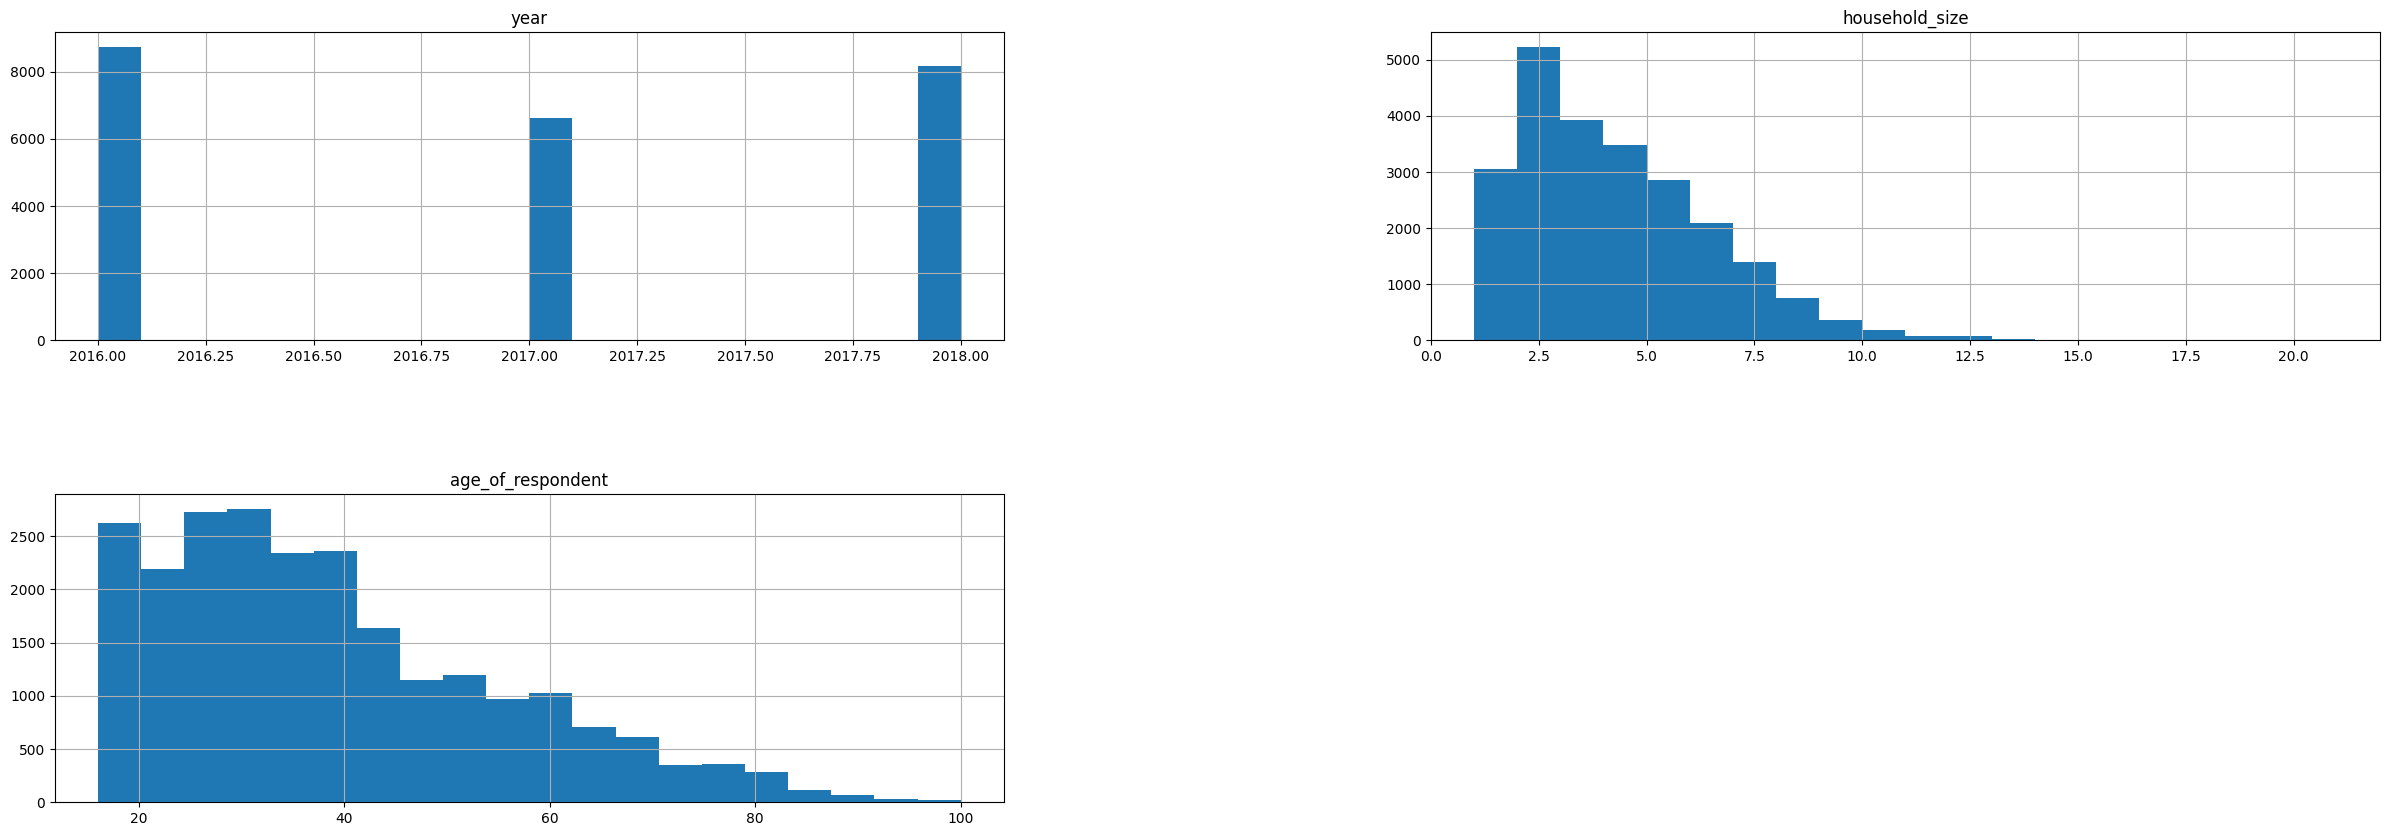

In [402]:
# numerical columns
train.drop('uniqueid', axis=1).hist(figsize=(30,10), bins=20)
plt.subplots_adjust(hspace=0.5, wspace=0.45)
plt.show()

- household size and age of respondent suggest a right-skewed distribution
- year suggest a bimodal distribution

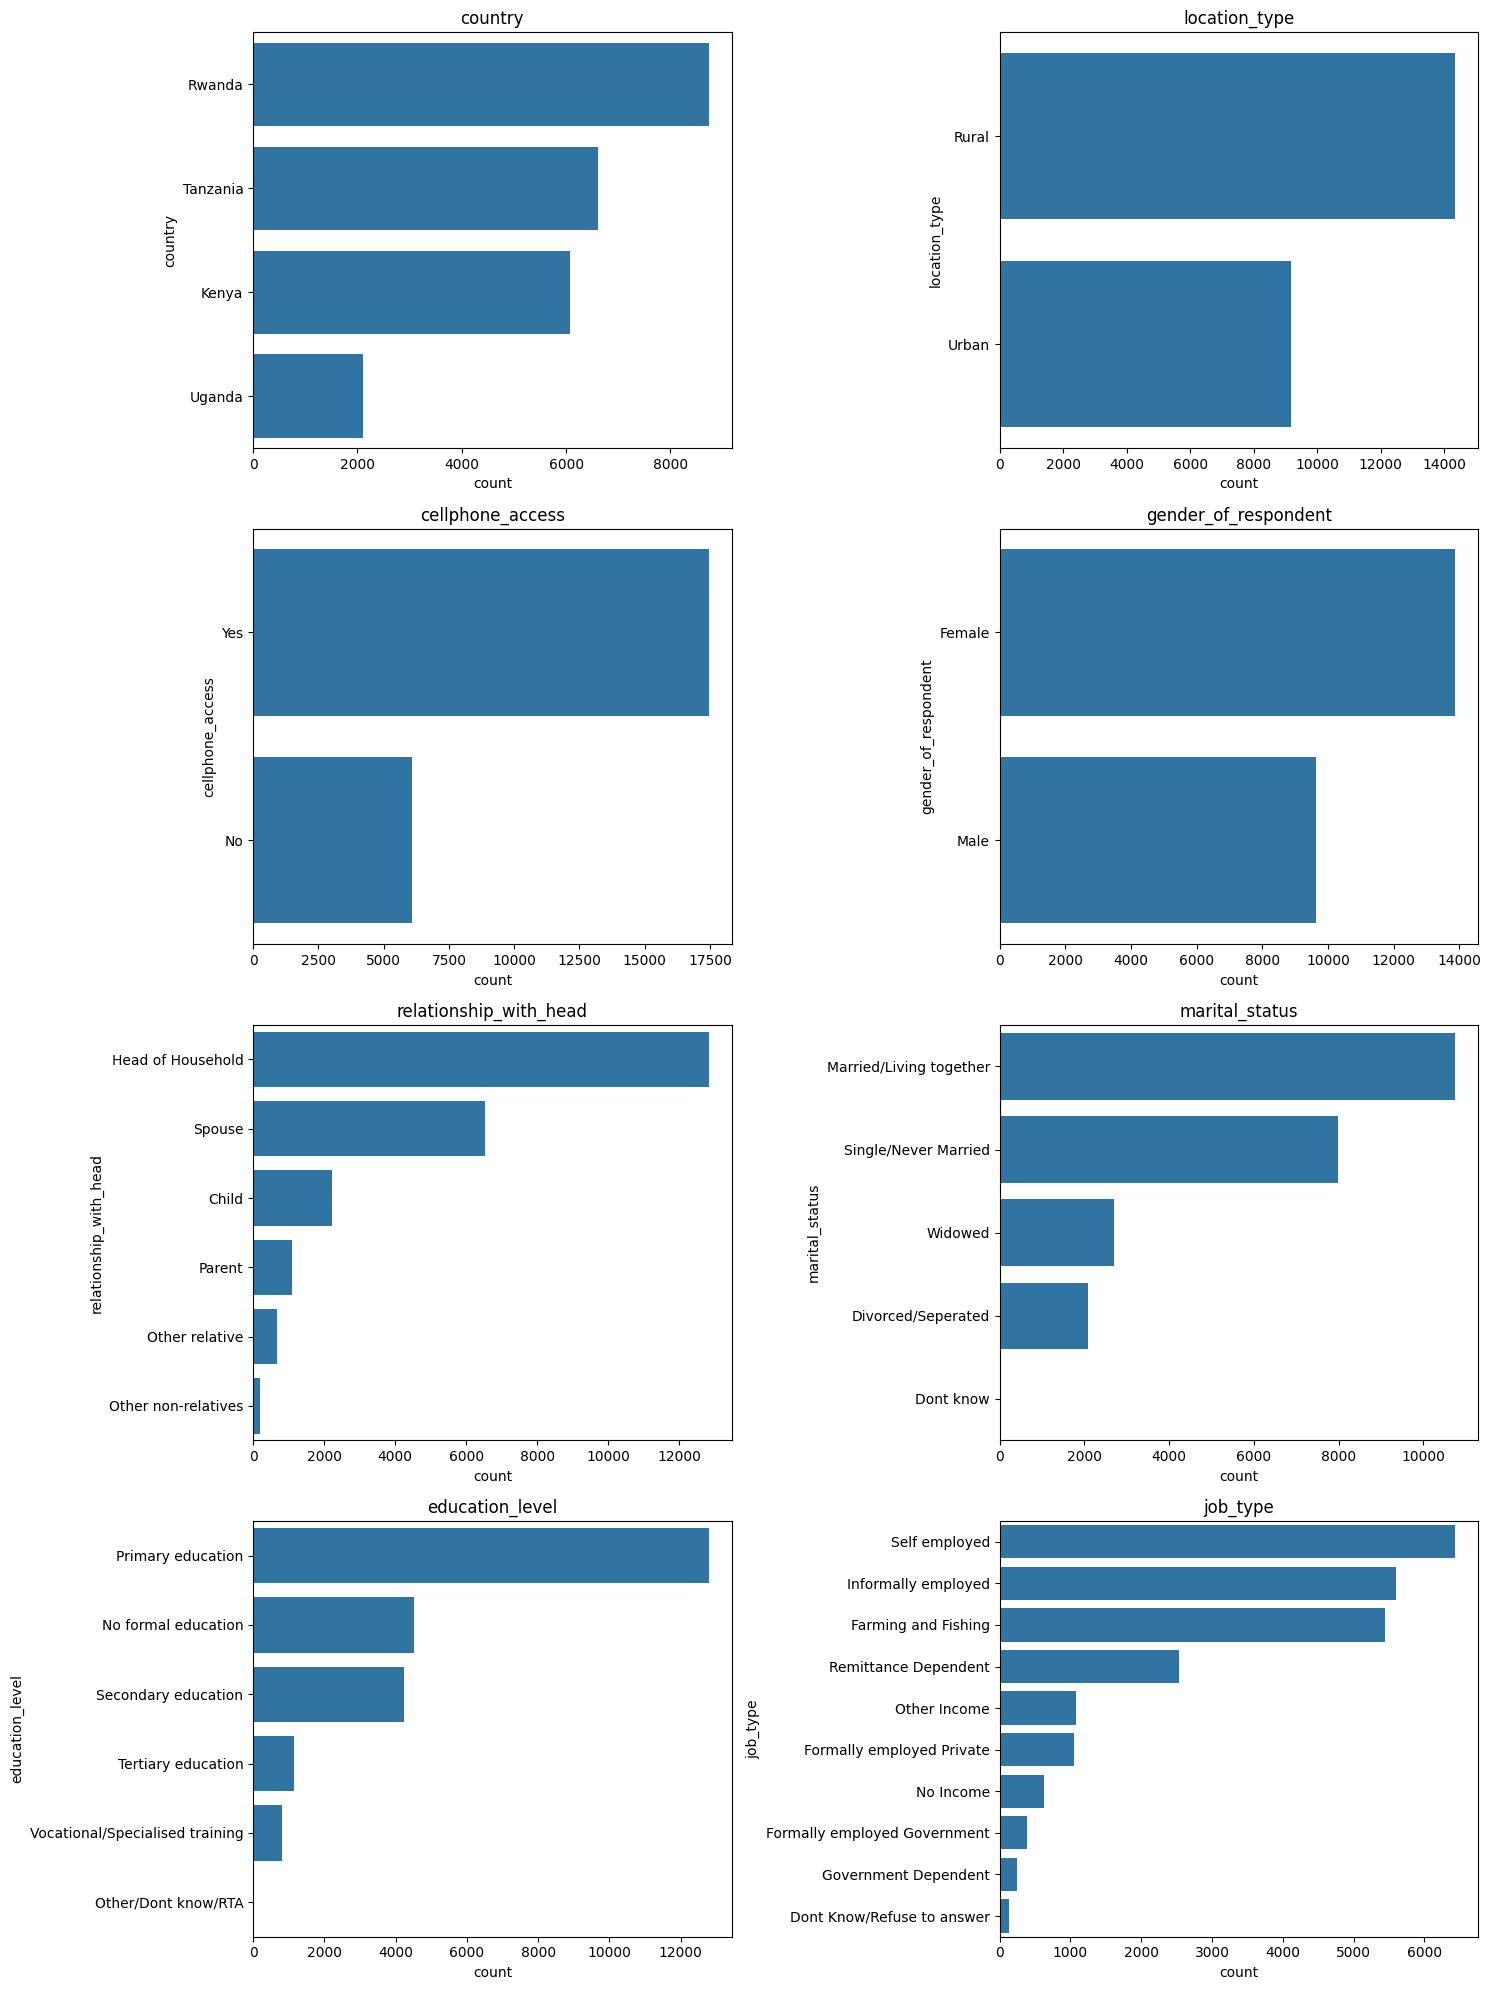

In [403]:
# categorical columns
plt.figure(figsize=(15, 20))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 2, i)
    sns.countplot(y=train[col], order=train[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

- most respondents are from Rwanda and Tanzania
- rural residents form the majority respondents
- A large proportion of individuals have cellphone access
- most respondents are female respondents
- many identified as heads of households and predominantly married or living together
- education levels are generally low, with primary education being the most common
- the labor market is dominated by self-employed and informally employed individuals

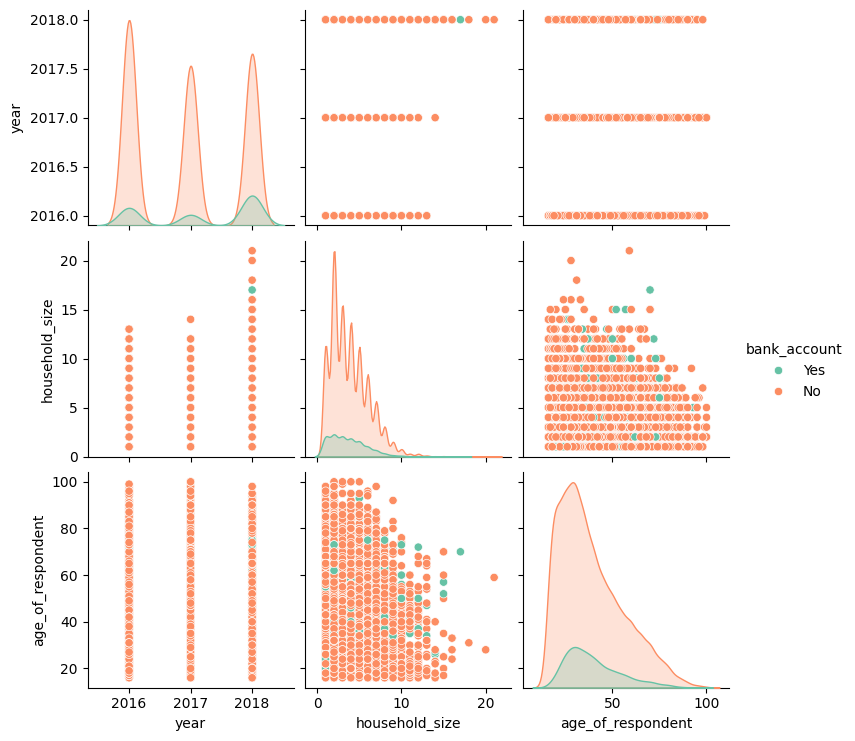

In [404]:
# are the classes linearly separable
sns.pairplot(train, hue='bank_account', palette='Set2')
plt.show()

The plot suggest that the data is not easily linearly separable using these features alone, implying that a simple linear classifier would likely struggle to effectively distinguish between those with and without bank accounts.

<Axes: >

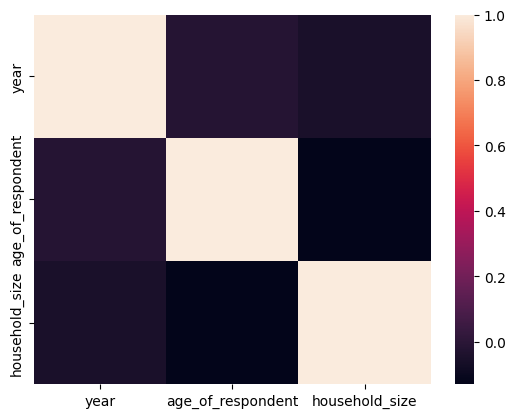

In [405]:
sns.heatmap(train[numeric_cols].corr())

- A strong positive correlation exists between year and age_of_respondent. 
- Similarly, age_of_respondent and household_size also exhibit a strong positive correlation, suggesting a potential connection between an individual's age and the structure or size of their household. 
- The relationship between year and household_size shows a weak positive correlation.

## Data preprocessing

Encoding

In [406]:
# target
train['bank_account'] = train['bank_account'].map({'Yes': 1, 'No': 0})

In [407]:
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

In [408]:
train_encoded = train_encoded.drop(columns=['uniqueid'])
train_encoded = train_encoded.fillna(0)

for col in train_encoded.select_dtypes(include=['bool']).columns:
    train_encoded[col] = train_encoded[col].astype(int)

train_encoded

,year,bank_account,household_size,age_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,location_type_Urban,cellphone_access_Yes,gender_of_respondent_Male,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,2018,1,3,24,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2018,0,5,70,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2018,1,5,26,0,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,1
3,2018,0,5,34,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,2018,0,8,26,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23519,2018,0,4,48,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
23520,2018,0,2,27,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
23521,2018,0,5,27,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
23522,2018,0,7,30,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


The dataset contained multiple categorical features such as gender, marital status, location type, education level, and job type. To prepare these variables for machine learning models, we encoded.

## Model Selection

In [409]:
X = train_encoded.drop('bank_account', axis=1)
y = train_encoded['bank_account']

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

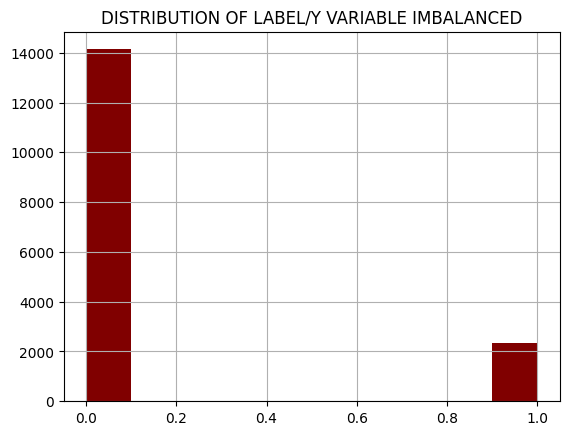

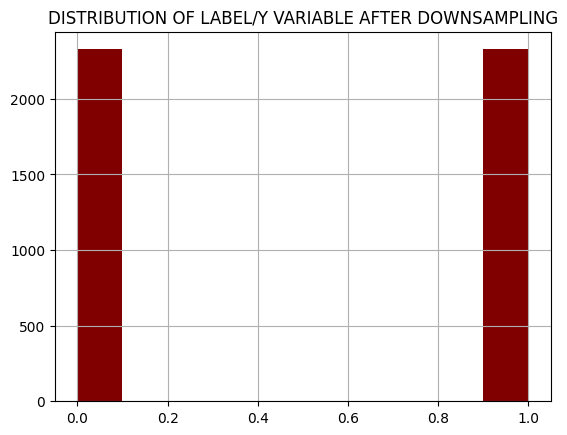

In [411]:
df_train = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority = df_train[df_train['bank_account'] == 0]
minority = df_train[df_train['bank_account'] == 1]

# Downsample majority class
majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=124
)

df_train_res = pd.concat([minority, majority_downsampled])

X_train_res = df_train_res.drop('bank_account', axis=1)
y_train_res = df_train_res['bank_account']

y_train.hist(color='Maroon')
plt.title('DISTRIBUTION OF LABEL/Y VARIABLE IMBALANCED')
plt.show()

y_train_res.hist(color='Maroon')
plt.title('DISTRIBUTION OF LABEL/Y VARIABLE AFTER DOWNSAMPLING')
plt.show()


Downsampling is preferred here because it maintains dataset integrity, avoids artificial respondents, and prevents overbalancing, all while still addressing class imbalance for modeling.

In [413]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [414]:
#Logistic Regression (No Regularisation)
pipe = make_pipeline(PolynomialFeatures(degree=1),LogisticRegression(C=1e10, solver='lbfgs', max_iter=10000, random_state=42))
scores = cross_val_score(pipe, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.73899033 0.77121375 0.77658432 0.76584318 0.75268817] 0.7610639501980758


In [415]:
# KNN
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=2, include_bias=False),KNeighborsClassifier(n_neighbors=5))
scores = cross_val_score(pipe, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.70998926 0.73576799 0.72824919 0.73899033 0.72688172] 0.7279756996177078


In [416]:
# Support vector classification - RBF Kernel
pipe = make_pipeline(PolynomialFeatures(degree=2), SVC(kernel='rbf',C=25))
scores = cross_val_score(pipe, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.74221267 0.76047261 0.76691729 0.76691729 0.74731183] 0.7567663398126653


In [417]:
# Support vector classification - Poly Kernel
pipe = make_pipeline(PolynomialFeatures(degree=1), SVC(kernel='poly',C=5))
scores = cross_val_score(pipe, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.73469388 0.74328679 0.75725027 0.75832438 0.74731183] 0.7481734289641153


In [418]:
# Support vector classification - Linear Kernel
pipe = make_pipeline(PolynomialFeatures(degree=2), LinearSVC(C=50))
scores = cross_val_score(pipe, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.74221267 0.74973147 0.75402793 0.75832438 0.74623656] 0.7501066029128121


In [419]:
# Decision tree
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=2, include_bias=False),DecisionTreeClassifier(random_state=42, max_depth=None))
scores = cross_val_score(pipe, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.68528464 0.66487648 0.68635875 0.6745435  0.68924731] 0.680062136909093


In [420]:
# Random Forest - Gini
pipe = make_pipeline(PolynomialFeatures(degree=1),RandomForestClassifier(n_estimators=1000,max_depth=10,criterion='gini'))
scores = cross_val_score(pipe, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.75080559 0.77228786 0.76584318 0.7593985  0.75376344] 0.7604197128766617


In [421]:
# Random Forest - Entropy
pipe = make_pipeline(PolynomialFeatures(degree=1),RandomForestClassifier(criterion='entropy', random_state=42))
scores = cross_val_score(pipe, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.72824919 0.71965628 0.7443609  0.73576799 0.72365591] 0.7303380571243778


Based on the evaluation scores, Logistic Regression emerged as the best-performing model, closely followed by Random Forest and SVM with a linear kernel. While these models showed competitive performance, Logistic Regression was chosen because it balances accuracy, interpretability, and computational efficiency, making it more suitable for this project compared to the more complex Random Forest

## Hyperparameter Tuning

In [422]:
log_reg = LogisticRegression(solver="liblinear", class_weight='balanced', random_state=42)

param_grid = {"C": np.logspace(-3, 3, 10),"penalty": ["l1", "l2"],"class_weight": [None, "balanced"]}
random_search = RandomizedSearchCV(estimator=log_reg,param_distributions=param_grid,n_iter=10,cv=5,scoring="f1",random_state=42,n_jobs=-1,verbose=2)
random_search.fit(X_train_res_scaled, y_train_res)

print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l1', 'class_weight': None, 'C': np.float64(0.46415888336127775)}
Best F1 Score: 0.7560656239794655


## Predicting the test data with the best performer

In [424]:
test = pd.read_csv('Test.csv')
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [425]:
# drop the ID
test_ids = test["uniqueid"].copy()
test = test.drop(['uniqueid'], axis=1)

In [426]:
# one hot encoding
test_encoded = pd.get_dummies(test, columns=categorical_cols, drop_first=True)
test_encoded = test_encoded.fillna(0)

for col in test_encoded.select_dtypes(include=['bool']).columns:
    test_encoded[col] = test_encoded[col].astype(int)

In [427]:
model = LogisticRegression(penalty="l2",C=1.0,solver="liblinear",max_iter=10000,random_state=42)
model.fit(X, y)
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)
y_pred = model.predict(test_encoded)

In [428]:
test['uniqueid_and_country'] = test_ids + " x " + test['country']
submission = pd.DataFrame({
    'uniqueid_and_country': test['uniqueid_and_country'],
    'bank_account': y_pred
})

submission.to_csv("submission.csv", index=False)

# Error analysis

Consolidated evaluation data

In [ ]:
# samples the model got wrong
eval_data = pd.DataFrame(X_test, columns=X_train.columns)
eval_data = eval_data.reset_index(drop=True)
eval_data['y_true'] = y_test.reset_index(drop=True)
eval_data['y_pred'] = pd.Series(y_pred).reset_index(drop=True)
eval_data['error'] = eval_data['y_pred'] != eval_data['y_true']

eval_data.head(10)

,year,household_size,age_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,location_type_Urban,cellphone_access_Yes,gender_of_respondent_Male,relationship_with_head_Head of Household,...,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,y_true,y_pred,error
0,2016,7,40,1,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,1,True
1,2016,3,24,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,True
2,2016,3,25,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,False
3,2017,1,35,0,1,0,1,1,0,1,...,0,0,0,0,0,0,1,0,0,False
4,2016,3,60,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,False
5,2016,5,28,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,False
6,2018,4,40,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,False
7,2018,2,50,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,True
8,2018,9,35,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,True
9,2016,4,34,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,True


Confusion matrix

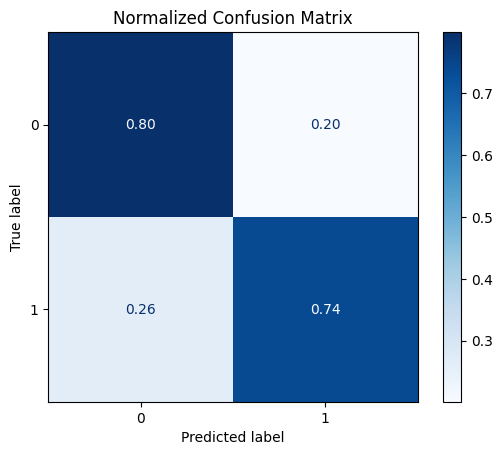

In [444]:
y_test_pred = random_search.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_test_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

The model achieves a True Positive rate of 74% and a True Negative rate of 80%, with 20% false positives and 26% false negatives, showing it performs slightly better at identifying negative cases than positive ones.

Error frequency per class

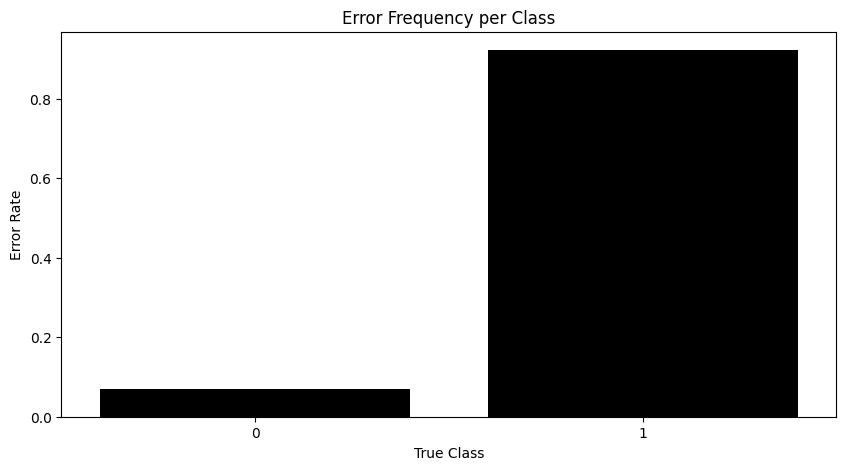

In [438]:
error_rate = eval_data.groupby('y_true')['error'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=error_rate, x='y_true', y='error', color='black')
plt.ylabel('Error Rate')
plt.xlabel('True Class')
plt.title('Error Frequency per Class')
plt.show()

The model shows a major performance imbalance: it classifies Class 0 very well with only an 8% error rate but struggles with Class 1, misclassifying it 90% of the time. This indicates the model is highly effective for negative cases but largely ineffective for positive cases, suggesting issues with data distribution, training, or class separability.

In [439]:
error_prone_classes = error_rate[error_rate['error'] > 0.2]['y_true'].tolist()

indices = []
pred_values = []
true_values = []

for cls in error_prone_classes:
    err = eval_data[(eval_data['y_true']==cls) & (eval_data['error']==True)]
    indices += list(err.index)
    pred_values += list(err['y_pred'])
    true_values += list(err['y_true'])

print("Number of misclassified rows in error-prone classes:", len(indices))

Number of misclassified rows in error-prone classes: 909


The model has 909 misclassified samples in the high-error classes. This highlights that certain classes are particularly challenging for the model, and these misclassifications can be further explored to understand patterns, data issues, or model weaknesses.

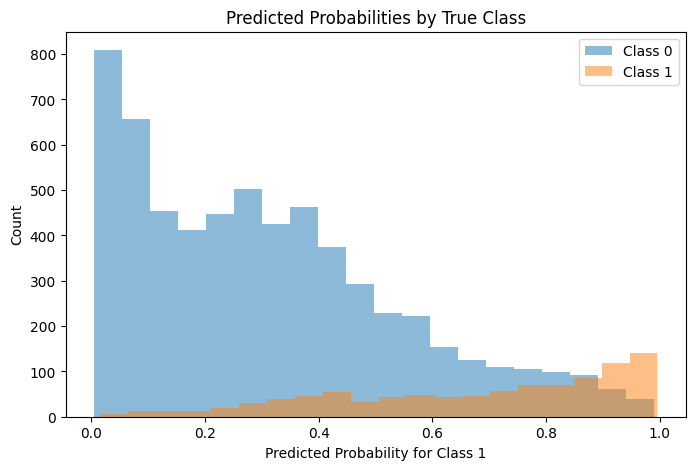

In [441]:
# predicted probability distribution per class
y_probs = random_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]

plt.figure(figsize=(8,5))
plt.hist(y_probs[y_test==0], bins=20, alpha=0.5, label='Class 0')
plt.hist(y_probs[y_test==1], bins=20, alpha=0.5, label='Class 1')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Count')
plt.title('Predicted Probabilities by True Class')
plt.legend()
plt.show()

The model generally separates the two classes well: true Class 0 instances mostly receive low probabilities for Class 1, and true Class 1 instances mostly receive high probabilities. Some overlap exists in the middle probability range (0.4–0.8), indicating areas where the model is less confident and misclassifications are more likely.

## Learning and loss curve

Learning Curve

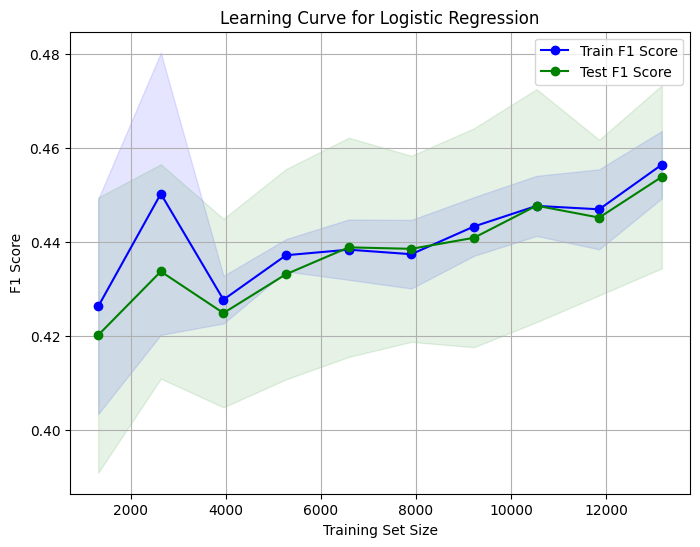

In [449]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(estimator=log_reg,X=X_train,y=y_train,cv=5,scoring='f1',n_jobs=-1,train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Train F1 Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Test F1 Score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")

plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


The learning curve suggests that the Logistic Regression model is benefiting from increasing training data, with the validation score showing a clear upward trend. While there is a generalization gap, the model appears to be moving towards a better fit and improved generalization with more data, and further data might be advantageous for optimal performance.

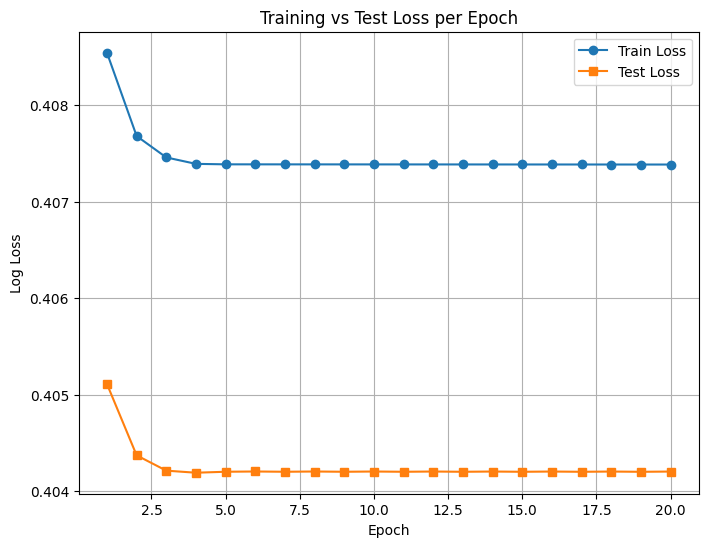

In [448]:
model = LogisticRegression(max_iter=1, warm_start=True, solver='lbfgs')

n_epochs = 20
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.fit(X_train, y_train)
    
    # Training loss
    y_train_prob = model.predict_proba(X_train)
    train_losses.append(log_loss(y_train, y_train_prob))
    
    # Test loss
    y_test_prob = model.predict_proba(X_test)
    test_losses.append(log_loss(y_test, y_test_prob))

plt.figure(figsize=(8,6))
plt.plot(range(1, n_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, n_epochs+1), test_losses, marker='s', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()